In [1]:
using BenchmarkTools

In [15]:
function simpleIterate(n::Integer, max_p::Real, madelung::Bool=false)::Real
    """
    Calculate the lattice sum `Σ_{i≠j} 1/(p_ij^n)` for particles within max_p of origin.
    
    `p_i,j`` is the distance between particles `i`` and `j``.
    It is in units of the nearest neighbour spacing `R` such that `r_ij = p_ij * R``

    The function assumes an infinite simple cubic lattice.
    We choose a single particle at origin and sum over all particles within `max_p`
    of it.

    This is done by iterating over every particle in a cube of dimensions `2*floor(max_p)` on each
    edge, centred on the origin. If the particle is within max_p of the origin we increment the particle
    count, `q`, for that distance. The particle at the origin is not counted.

    The distances `p` are then raised to the appropriate exponent and multiplied by
    the particle count at that distance `q[p]` to give the lattice sum.

    If `madelung=true` then we instead calculate the Madelung constant `Σ_{i≠j} ±1/(p_ij)`
    where the sign is determined by the sign of the charge. This is calculated for n=1.
    """
    
    if madelung && n != 1
        error("Madelung constant calculation requires n=1. Currently n=$n.")
    end

    # q gives the number of particles at distance p from the considered particle.
    # p is p_ij, as above.
    sumDict = Dict(1.0 => 0) # key: p; value: q

    bounds = floor(max_p)

    for i in -bounds:bounds
        for j in -bounds:bounds
            for k in -bounds:bounds
                p = sqrt(i^2 + j^2 + k^2)
                if p <= max_p && p != 0
                    if madelung
                        sumDict[p] = get(sumDict, p, 0) + (-1)^(i+j+k)
                    else
                        sumDict[p] = get(sumDict, p, 0) + 1
                    end
                end
            end
        end
    end

    latticeSum = 0

    for (p, q) in sumDict
        latticeSum += (q / p^n)
    end

    return latticeSum
end

si6 = simpleIterate(6, 3.5)
si12 = simpleIterate(12, 3.5)

print("With n=6, A_n=$si6, error=$(si6-8.40)\n")
print("With n=12, A_n=$si12, error=$(si12-6.20)")

With n=6, A_n=8.30440835563316, error=-0.09559164436683965
With n=12, A_n=6.202131637160059, error=0.002131637160059263

In [17]:
function planarIterate(n::Integer, max_p::Real, madelung::Bool=false, cubic::Bool=false)::Real
    """
    Calculate the lattice sum `Σ_{i≠j} 1/(p_ij^n)` for particles within max_p of origin.
    
    `p_i,j`` is the distance between particles `i`` and `j``.
    It is in units of the nearest neighbour spacing `R` such that `r_ij = p_ij * R``

    The function assumes an infinite simple cubic lattice.
    We choose a single particle at origin and sum over all particles within `max_p`
    of it.

    This is done by iterating over every particle in a plane of dimensions `2*floor(max_p)` on each
    edge, centred on (0,0,0) and perpendicular to the z-axis. If the particle is within max_p of the
    origin we increment the particle count, `q`, for that distance. The particle at the origin is not counted.
    We then displace the plane by 1 in the z-axis and recalculate the distances. This is repeated until the planes
    have swept through `-floor(max_p) < z < floor(max_p)` and thus covered a cube `2*floor(max_p)` on a side and
    centred on the origin.

    The distances `p` are then raised to the appropriate exponent and multiplied by
    the particle count at that distance `q[p]` to give the lattice sum.

    If `madelung=true` then we instead calculate the Madelung constant `Σ_{i≠j} ±1/(p_ij)`
    where the sign is determined by the sign of the charge. This is calculated for n=1.

    If `cubic=true` then the check that any point is within `max_p` is suppressed.
    This causes summation over cubes instead of spheres, which is necessary for the
    convergence of the Madelung constant of NaCl.
    """
    
    if madelung && n != 1
        error("Madelung constant calculation requires n=1. Currently n=$n.")
    end
    
    # q gives the number of particles at distance p from the considered particle.
    # p is p_ij, as above.
    planeDict = Dict(1.0 => 0) # key: p; value: q

    bounds = floor(max_p)

    for i in -bounds:bounds
        for j in -bounds:bounds
            p = sqrt(i^2 + j^2)
            if p != 0 && (cubic || p <= max_p)
                if madelung
                    planeDict[p] = get(planeDict, p, 0) + (-1)^(i+j)
                else
                    planeDict[p] = get(planeDict, p, 0) + 1
                end
            end
        end
    end

    sumDict = copy(planeDict)

    planeDict[0] = 1
    
    for k in 1:bounds
        for (p, q) in planeDict
            p = sqrt(p^2 + k^2) # Adjust distance for plane displacement
            if cubic || p <= max_p
                if madelung && mod(k, 2) == 1 # Alternate charge polarity
                    sumDict[p] = get(sumDict, p, 0) - 2 * q
                else
                    sumDict[p] = get(sumDict, p, 0) + 2 * q # Symmetry exploit: By adding 2 we can skip going over -bounds:-1
                end
            end
        end
    end
    
    latticeSum = 0

    for (p, q) in sumDict
        latticeSum += (q / p^n)
    end

    return latticeSum
end

pi6 = planarIterate(6, 3.5)
pi12 = planarIterate(12, 3.5)

print("With n=6, A_n=$pi6, error=$(pi6-8.40)\n")
print("With n=12, A_n=$pi12, error=$(pi12-6.20)")

With n=6, A_n=8.30440835563316, error=-0.09559164436683965
With n=12, A_n=6.202131637160059, error=0.002131637160059263

In [4]:
@benchmark simpleIterate(12, 3.5) evals=10

BenchmarkTools.Trial: 3125 samples with 10 evaluations.
 Range (min … max):   44.530 μs … 704.740 μs  ┊ GC (min … max): 0.00% … 70.94%
 Time  (median):     152.920 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   157.155 μs ±  68.982 μs  ┊ GC (mean ± σ):  0.10% ±  1.27%

      ▄█▃▃▂▂▂▁   ▁▁▁     ▁▁▂ ▃▂▁▁▁  ▇▃                           
  ▂▄▆▆████████████████████████████▇████▅▆▆▄▅▆█▇▅▅▄▃▃▃▂▃▄▃▄▄▄▅▄▃ ▅
  44.5 μs          Histogram: frequency by time          312 μs <

 Memory estimate: 1.78 KiB, allocs estimate: 7.

In [5]:
@benchmark planarIterate(12, 3.5) evals=10

BenchmarkTools.Trial: 10000 samples with 10 evaluations.
 Range (min … max):   5.910 μs …  1.090 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     45.690 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   46.275 μs ± 28.398 μs  ┊ GC (mean ± σ):  0.81% ± 2.08%

               ▄ ▁      ▁      ▂█▅                             
  ▂▂▇▃▂▁▂▁▆▄▅▄▆█▇█▇▇█▇█▅█▇▇▆▅▅▆██████▆▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  5.91 μs         Histogram: frequency by time         103 μs <

 Memory estimate: 2.31 KiB, allocs estimate: 11.

In [18]:
# Madelung constant calculation
siM = simpleIterate(1, 3.5, true)
print("With simpleIterate, α=$siM, error=$(siM-1.7476)\n")
piM = planarIterate(1, 3.5, true)
print("With planarIterate, α=$piM, error=$(piM-1.7476)\n")
cpiM = planarIterate(1, 3.5, true, true)
print("With planarIterate, α=$cpiM, error=$(cpiM-1.7476)\n")

With simpleIterate, α=-3.163452221729142, error=-4.911052221729142
With planarIterate, α=-3.163452221729142, error=-4.911052221729142
With planarIterate, α=-1.9125039789591556, error=-3.660103978959156


In [7]:
using Plots

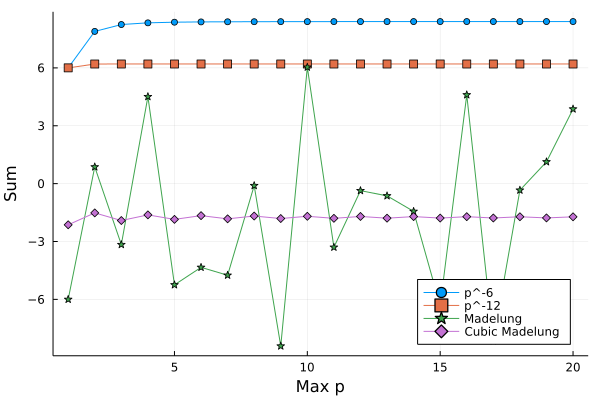

In [20]:
rVec = 1:20
y6 = Vector{Real}(undef, length(rVec))
y12 = Vector{Real}(undef, length(rVec))
yMad = Vector{Real}(undef, length(rVec))
yCMad = Vector{Real}(undef, length(rVec))

for r in rVec
    y6[r] = planarIterate(6, r, false)
    y12[r] = planarIterate(12, r, false, false)
    yMad[r] = planarIterate(1, r, true, false)
    yCMad[r] = planarIterate(1, r, true, true)
end

plot(rVec, y6, marker=:auto, label="p^-6", legend=:bottomright, xlabel="Max p", ylabel="Sum")
plot!(rVec, y12, marker=:auto, label="p^-12")
plot!(rVec, yMad, marker=:auto, label="Madelung")
plot!(rVec, yCMad, marker=:auto, label="Cubic Madelung")